<a href="https://colab.research.google.com/github/JieShengm/scTransformer_MAE/blob/main/%5BscTransformer%5Dzhengmix8eq_knn%26cell_representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prep

In [1]:
cd /content/drive/MyDrive/scmae

[Errno 2] No such file or directory: '/content/drive/MyDrive/scmae'
/content


In [2]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from torchvision import transforms as pth_transforms
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !pip3 install umap-learn
    !pip3 install scprep
    !pip3 install anndata
#    !git clone https://github.com/facebookresearch/mae.git
#    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

import umap
import math
import scprep

umap_operator = umap.UMAP(n_components=2) # n_components = 2: 2-dim umap 

Running in Colab.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 16.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 5.6 MB/s 
     |████████████████████████████████| 1.1 MB 64.5 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=0791a8deb79ba0dd61c3ab44bbf557bae55dc34222265c3a4a255f10ecdad1e2
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=c89d0a095de87c403f99370138555c073a7f736a28550237f48aa19e5e8aef2b
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/s

ModuleNotFoundError: ignored

In [ ]:
from torchvision import datasets
import torch.distributed as dist
from torch import nn
import pandas as pd
from util.datasets import scRNACSV
from util import misc as utils
import torch.backends.cudnn as cudnn
import argparse

# Main functions

In [ ]:
class ReturnIndexDataset(datasets.ImageFolder):
    def __getitem__(self, idx):
        img, lab = super(ReturnIndexDataset, self).__getitem__(idx)
        return img, idx

In [ ]:
class Crop(object):
    #def __init__(self):
    #    self.totensor = pth_transforms.ToTensor()

    def __call__(self, x):
        length = x.shape[0]
        index = np.arange(length)

        corr = torch.from_numpy(index)
        vec = torch.cat([x, corr]).float()
#        vec = torch.cat([data, corr]).long()

        return vec

In [ ]:
def extract_feature_pipeline(args, data_loader_train, data_loader_val, train_labels, test_labels, gene_numer):
    # ============ building network ... ============
    model = getattr(models_mae, args.model)(gene_embed_dim = args.gene_embed_dim, gene_number = args.gene_number)
    print(model)
    #model = models_mae.__dict__[args.model](norm_pix_loss=args.norm_pix_loss)
    print(f"Model {args.model} built.")
    model.cuda()
    checkpoint = torch.load(args.pretrained_weights, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    model.eval()

    # ============ extract features ... ============
    print("Extracting features for train set...")
    train_features = extract_features(model, data_loader_train)
    print("Extracting features for val set...")
    test_features = extract_features(model, data_loader_val)

    if utils.get_rank() == 0:
        train_features = nn.functional.normalize(train_features, dim=1, p=2)
        test_features = nn.functional.normalize(test_features, dim=1, p=2)
    # # save features and labels
    if args.dump_features and dist.get_rank() == 0:
        torch.save(train_features.cpu(), os.path.join(args.dump_features, "trainfeat.pth"))
        torch.save(test_features.cpu(), os.path.join(args.dump_features, "testfeat.pth"))
        torch.save(train_labels.cpu(), os.path.join(args.dump_features, "trainlabels.pth"))
        torch.save(test_labels.cpu(), os.path.join(args.dump_features, "testlabels.pth"))
    return train_features, test_features, train_labels, test_labels

In [ ]:
@torch.no_grad()
def extract_features(model, data_loader):
    metric_logger = utils.MetricLogger(delimiter="  ")
    features = None
    for samples, index in metric_logger.log_every(data_loader, 10):
        #print(f'This is a round')
        samples = samples.cuda(non_blocking=True)
        index = index.cuda(non_blocking=True)
        _, _, _, feats = model(samples, mask_ratio=args.mask_ratio)#.clone()
        feats = feats.clone()
        #print(f'This is feats {feats}')
        # init storage feature matrix
        if dist.get_rank() == 0 and features is None:
            features = feats
        else:
            features = torch.cat((features, feats), dim = 0)
    return features

In [ ]:
@torch.no_grad()
def knn_classifier(train_features, train_labels, test_features, test_labels, k, T, num_classes=1000):
    top1, top5, total = 0.0, 0.0, 0
    train_features = train_features.t()
    num_test_images, num_chunks = test_labels.shape[0], 100
    imgs_per_chunk = num_test_images // num_chunks
    retrieval_one_hot = torch.zeros(k, num_classes).cuda()
    for idx in range(0, num_test_images, imgs_per_chunk):
        # get the features for test images
        features = test_features[
            idx : min((idx + imgs_per_chunk), num_test_images), :
        ]
        targets = test_labels[idx : min((idx + imgs_per_chunk), num_test_images)]
        batch_size = targets.shape[0]

        # calculate the dot product and compute top-k neighbors
        similarity = torch.mm(features, train_features)
        distances, indices = similarity.topk(k, largest=True, sorted=True)
        candidates = train_labels.view(1, -1).expand(batch_size, -1)
        retrieved_neighbors = torch.gather(candidates.cuda(), 1, indices)

        retrieval_one_hot.resize_(batch_size * k, num_classes).zero_()
        retrieval_one_hot.scatter_(1, retrieved_neighbors.view(-1, 1), 1)
        distances_transform = distances.clone().div_(T).exp_()
        probs = torch.sum(
            torch.mul(
                retrieval_one_hot.view(batch_size, -1, num_classes),
                distances_transform.view(batch_size, -1, 1),
            ),
            1,
        )
        _, predictions = probs.sort(1, True)

        # find the predictions that match the target
        correct = predictions.eq(targets.data.view(-1, 1).cuda())
        top1 = top1 + correct.narrow(1, 0, 1).sum().item()
        top5 = top5 + correct.narrow(1, 0, 5).sum().item()
        total += targets.size(0)
    top1 = top1 * 100.0 / total
    top5 = top5 * 100.0 / total
    return top1, top5


# Argument

In [ ]:
parser = argparse.ArgumentParser()

parser.add_argument('--batch_size_per_gpu', default=64, type=int,
                    help='Batch size per GPU (effective batch size is batch_size * accum_iter * # gpus')
parser.add_argument('--model', default='mae_vit_large_patch16', type=str, metavar='MODEL',
                    help='Name of model to train')
parser.add_argument('--norm_pix_loss', action='store_true',
                        help='Use (per-patch) normalized pixels as targets for computing loss')
parser.set_defaults(norm_pix_loss=False)
parser.add_argument('--pretrained_weights', default='', type=str, help="Path to pretrained weights to evaluate.")
parser.add_argument('--mask_ratio', default=0., type=float,
                    help='Masking ratio (percentage of removed patches).')
parser.add_argument('--dump_features', default=None,
                    help='Path where to save computed features, empty for no saving')
parser.add_argument('--gene_embed_dim', default=8, type=int,
                        help='Dimension of gene embedding.')
parser.add_argument('--gene_number', default=2000, type=int,
                        help='Number of gene.')

# Dataset parameters
parser.add_argument('--expr_path', default='/path/to/imagenet/train/', type=str,
        help='Please specify path to the expression matrix.')
parser.add_argument('--meta_path', default='/path/to/imagenet/train/', type=str,
        help='Please specify path to the meta file.')
parser.add_argument('--label_name', default='perturb', type=str,
                    help='Please specify the name of label column in the meta file.')
parser.add_argument('--num_workers', default=10, type=int)
parser.add_argument('--load_features', default=None, help="""If the features have
        already been computed, where to find them.""")
parser.add_argument('--nb_knn', default=[10, 20, 100, 200], nargs='+', type=int,
                    help='Number of NN to use. 20 is usually working the best.')
parser.add_argument('--temperature', default=0.07, type=float,
                    help='Temperature used in the voting coefficient')
    
# distributed training parameters
parser.add_argument('--world_size', default=1, type=int,
                    help='number of distributed processes')
parser.add_argument('--local_rank', default=-1, type=int)
parser.add_argument('--dist_on_itp', action='store_true')
parser.add_argument('--dist_url', default='env://',
                    help='url used to set up distributed training')
parser.add_argument('--use_cuda', action='store_true',
        help="Should we store the features on GPU? We recommend setting this to False if you encounter OOM")
parser.set_defaults(use_cuda=False)
parser.add_argument('--seed', default=0, type=int, help="""Random seed""")



_StoreAction(option_strings=['--seed'], dest='seed', nargs=None, const=None, default=0, type=<class 'int'>, choices=None, help='Random seed', metavar=None)

# Change arguments below

In [ ]:
args = parser.parse_args(args=['--model', 'mae_vit_d64', 
                               '--batch_size_per_gpu', '4',
                               '--pretrained_weights', '../scmae/checkpoint-4600.pth',
                               '--expr_path', '/content/drive/Shareddrives/Documentation/Jie_Sheng/Zhengmix8eq/Zhengmix8eq.csv',
                               '--meta_path', '/content/drive/Shareddrives/Documentation/Jie_Sheng/Zhengmix8eq/meta.csv',
                               '--label_name', 'x',
                               '--local_rank', '0',
                               '--gene_embed_dim', '64',
                               '--gene_number', '10198',
                               ])
print(args)

Namespace(batch_size_per_gpu=4, dist_on_itp=False, dist_url='env://', dump_features=None, expr_path='/content/drive/Shareddrives/Documentation/Jie_Sheng/Zhengmix8eq/Zhengmix8eq.csv', gene_embed_dim=64, gene_number=10198, label_name='x', load_features=None, local_rank=0, mask_ratio=0.0, meta_path='/content/drive/Shareddrives/Documentation/Jie_Sheng/Zhengmix8eq/meta.csv', model='mae_vit_d64', nb_knn=[10, 20, 100, 200], norm_pix_loss=False, num_workers=10, pretrained_weights='../scmae/checkpoint-4600.pth', seed=0, temperature=0.07, use_cuda=False, world_size=1)


# knn accuracy

In [ ]:
utils.init_distributed_mode_dino(args) # Run only once

Will run the code on one GPU.
| distributed init (rank 0): env://


In [ ]:
#utils.init_distributed_mode_dino(args)
print("git:\n  {}\n".format(utils.get_sha()))
print("\n".join("%s: %s" % (k, str(v)) for k, v in sorted(dict(vars(args)).items())))
cudnn.benchmark = True

[21:39:09.298959] git:
  sha: N/A, status: clean, branch: N/A

[21:39:09.299265] batch_size_per_gpu: 4
dist_on_itp: False
dist_url: env://
dump_features: None
expr_path: /content/drive/Shareddrives/Documentation/Jie_Sheng/Zhengmix8eq/Zhengmix8eq.csv
gene_embed_dim: 64
gene_number: 10198
gpu: 0
label_name: x
load_features: None
local_rank: 0
mask_ratio: 0.0
meta_path: /content/drive/Shareddrives/Documentation/Jie_Sheng/Zhengmix8eq/meta.csv
model: mae_vit_d64
nb_knn: [10, 20, 100, 200]
norm_pix_loss: False
num_workers: 10
pretrained_weights: ../scmae/checkpoint-4600.pth
rank: 0
seed: 0
temperature: 0.07
use_cuda: False
world_size: 1


In [ ]:
# ============ preparing data ... ============
expr = pd.read_csv(args.expr_path, index_col=0)
meta = pd.read_csv(args.meta_path, index_col=0)
gene_number = expr.shape[0]

print(f'This dataset has {gene_number} genes!')

#crop = Crop()

dataset = scRNACSV(expr, meta, args.label_name, instance=True)

trainset_length = int(len(dataset) * 0.8)
testset_length = len(dataset) - trainset_length
dataset_train, dataset_val = torch.utils.data.random_split(dataset, [trainset_length, testset_length],
                                                               generator=torch.Generator().manual_seed(args.seed))
train_labels = torch.tensor([dataset_train.dataset.labels[i] for i in dataset_train.indices]).long()
test_labels = torch.tensor([dataset_val.dataset.labels[i] for i in dataset_val.indices]).long()

sampler = torch.utils.data.DistributedSampler(dataset_train, shuffle=False)
data_loader_train = torch.utils.data.DataLoader(
    dataset_train,
    sampler=sampler,
    batch_size=args.batch_size_per_gpu,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=False,
)
data_loader_val = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=args.batch_size_per_gpu,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=False,
)
print(f"Data loaded with {len(dataset_train)} train and {len(dataset_val)} val cells.")


[21:39:20.001950] This dataset has 10198 genes!
[21:39:20.046381] This is the label dictionary of this dataset {'b.cells': 0, 'cd14.monocytes': 1, 'cd4.t.helper': 2, 'cd56.nk': 3, 'memory.t': 4, 'naive.cytotoxic': 5, 'naive.t': 6, 'regulatory.t': 7}
[21:39:20.051397] Data loaded with 3195 train and 799 val cells.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
if args.load_features:
    train_features = torch.load(os.path.join(args.load_features, "trainfeat.pth"))
    test_features = torch.load(os.path.join(args.load_features, "testfeat.pth"))
    train_labels = torch.load(os.path.join(args.load_features, "trainlabels.pth"))
    test_labels = torch.load(os.path.join(args.load_features, "testlabels.pth"))
else:
    # need to extract features !
    train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args, data_loader_train, data_loader_val, train_labels, test_labels, gene_number)

if utils.get_rank() == 0:
    if args.use_cuda:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args.nb_knn:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, args.temperature)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
dist.barrier()

[21:39:20.089828] MaskedAutoencoderViT(
  (pos_embed): Embedding(10198, 64)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=64, out_features=192, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=64, out_features=256, bias=True)
        (act): GELU(approximate=none)
        (fc2): Linear(in_features=256, out_features=64, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=64, out_features=192, bias=True)
        (attn_drop): Dr

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[21:39:21.652008]   [  0/799]  eta: 0:20:05    time: 1.5094  data: 0.4978  max mem: 6433
[21:39:25.337869]   [ 10/799]  eta: 0:06:12    time: 0.4722  data: 0.0457  max mem: 6433
[21:39:29.036203]   [ 20/799]  eta: 0:05:29    time: 0.3691  data: 0.0003  max mem: 6433
[21:39:32.733120]   [ 30/799]  eta: 0:05:12    time: 0.3697  data: 0.0002  max mem: 6433
[21:39:36.430956]   [ 40/799]  eta: 0:05:01    time: 0.3696  data: 0.0002  max mem: 6533
[21:39:40.127983]   [ 50/799]  eta: 0:04:53    time: 0.3696  data: 0.0002  max mem: 6533
[21:39:43.825344]   [ 60/799]  eta: 0:04:46    time: 0.3696  data: 0.0003  max mem: 6533
[21:39:47.524267]   [ 70/799]  eta: 0:04:41    time: 0.3697  data: 0.0003  max mem: 6533
[21:39:51.220757]   [ 80/799]  eta: 0:04:35    time: 0.3697  data: 0.0003  max mem: 6533
[21:39:54.918001]   [ 90/799]  eta: 0:04:30    time: 0.3696  data: 0.0003  max mem: 6533
[21:39:58.614673]   [100/799]  eta: 0:04:26    time: 0.3696  data: 0.0003  max mem: 6533
[21:40:02.313249]   [

# Cell representation (tSNE)

In [ ]:
#pip install sklearn
import sklearn
import scprep

In [ ]:
tsne_operator = sklearn.manifold.TSNE(n_components=2,random_state=42, perplexity=30)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


{'b.cells': 0,
 'cd14.monocytes': 1,
 'cd4.t.helper': 2,
 'cd56.nk': 3,
 'memory.t': 4,
 'naive.cytotoxic': 5,
 'naive.t': 6,
 'regulatory.t': 7}

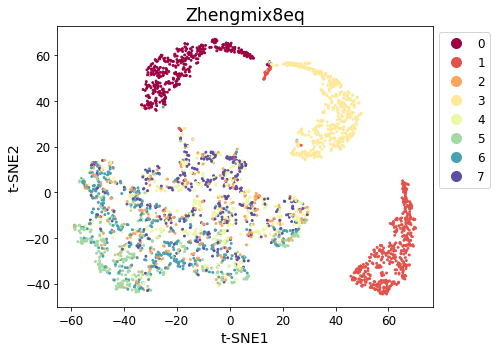

In [ ]:
# ================= save output ... ========================
tr_features = train_features.cpu().numpy()
tr_labels = train_labels.cpu().numpy()
te_features = test_features.cpu().numpy()
te_labels = test_labels.cpu().numpy()
# ================= visualization ... ========================
data_tsne = tsne_operator.fit_transform(tr_features) # data is first moved to cpu 
#data_umap = pd.DataFrame(data_umap, index=te_labels)
scprep.plot.scatter2d(data_tsne, c=tr_labels, cmap='Spectral', # colormap
                      ticks=True, label_prefix='t-SNE', title="Zhengmix8eq",
                      legend_anchor=(1,1), figsize=(7,5))

{'b.cells': 0, 
 'cd14.monocytes': 1, 
 'cd4.t.helper': 2, 
 'cd56.nk': 3, 
 'memory.t': 4, 
 'naive.cytotoxic': 5, 
 'naive.t': 6, 
 'regulatory.t': 7}


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


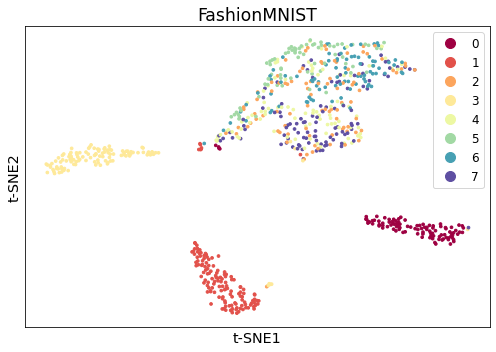

In [ ]:
data_tsne = tsne_operator.fit_transform(te_features) # data is first moved to cpu 
#data_umap = pd.DataFrame(data_umap, index=te_labels)
scprep.plot.scatter2d(data_tsne, c=te_labels, cmap='Spectral', # colormap
                      ticks=False, label_prefix='t-SNE', title="FashionMNIST",
                      legend_anchor=(1,1), figsize=(7,5))